# Анализ пространственных данных. Домашнее задание №2

Мягкий дедлайн: __4 ноября 2020 г. 23:59__

Жесткий дедлайн (со штрафом в _50%_ от количества набранных вами за ДЗ баллов): __5 ноября 2020 г. 08:59__

Визуализация "чего-либо" __без__ выполненного основного задания оценивается в __0 баллов__

ФИО: `Налиткин Александр Сергеевич`

Группа: `DS-12`

In [ ]:
!pip install geopandas
!pip install shapely
!pip install OSMPythonTools
!pip install folium
!pip install earthpy

In [ ]:
import matplotlib.pyplot as plt
import os
import numpy as np
import pandas as pd
from tqdm.notebook import tqdm

In [ ]:
import geopandas as gpd
from shapely.geometry import Point, LineString
import earthpy
import pyproj
# import pysal

In [ ]:
from OSMPythonTools.api import Api
from OSMPythonTools.overpass import Overpass, overpassQueryBuilder
from OSMPythonTools.nominatim import Nominatim
import json
import requests

## Задание №1. Горячая точка (алгоритм - 10 баллов, визуализация - 10 баллов).

Генерируйте рандомные точки на планете Земля до тех пор, пока не попадете на территорию ``Афганистана``

1. Вы можете использовать функции принадлжености точки полигону и расстояния от точки до полигона (в метрах)
2. Предложите не наивный алгоритм поиска (генерировать __напрямую__ точку из полигона границ Афганистана __запрещено__)
 - под "не наивным" алгоритмом имеется ввиду пошаговое сужение границ полигона, из которого рандомно генерируется точка (первоначальный полигон - вся планета Земля)

Границы можно получить несколькими способами

In [ ]:
#### Способ 1

nominatim = Nominatim()
overpass = Overpass()

areaId = nominatim.query('Afghanistan').areaId()
print(areaId)

query = overpassQueryBuilder(area = areaId,
                             elementType = ['relation'],
                             selector='"admin_level"=2',
                             includeGeometry=True)
result = overpass.query(query, timeout = 60)
print(len(result.elements()))

firstElement = result.elements()[0]
len(firstElement.geometry()['coordinates'][0])

[nominatim] downloading data: search
[overpass] downloading data: [timeout:60][out:json];area(3600303427)->.searchArea;(relation["admin_level"=2](area.searchArea);); out body geom;


3600303427
1


46210

In [ ]:
#### Способ 2

# https://nominatim.openstreetmap.org/search?country=Afghanistan&polygon_geojson=1&format=json

Запрашиваем нужный relation с геометрией по ISO-коду

In [ ]:
#### Cпособ 3 (почти как 1)

overpass_url = "http://overpass-api.de/api/interpreter"
overpass_query = """
[out:json];
(
relation["ISO3166-1"="AF"][admin_level=2];
);
out geom;
"""
response = requests.get(overpass_url, params={'data': overpass_query})
data = response.json()

Фильтруем только границы - way and outer

In [ ]:
rel_members = data['elements'][0]['members']

borders = []

for mem in rel_members:

    if mem['type'] == 'way' and mem['role'] == 'outer':
        borders.append(mem['geometry'])

In [ ]:
len(borders)

251

In [ ]:
border_polygon = [v for way in borders for v in way]
len(border_polygon)

46460

Собираем геометрию для отрисовки

In [ ]:
geometry = pd.Series([Point()] * len(border_polygon))

for i, node in enumerate(border_polygon):
    
    geometry[i] = Point(node['lon'], node['lat'])  #x = lon, y = lat
    
AF_data_all = gpd.GeoDataFrame({'geometry':geometry}, crs = 'EPSG:4326')

In [ ]:
AF_data = AF_data_all.drop_duplicates()  #### дубликаты как раз содержатся в начале каждого следующего way
print(AF_data.shape)
AF_data.head()

(46209, 1)


,geometry
0,POINT (73.84125 36.92594)
1,POINT (73.83592 36.92528)
2,POINT (73.83519 36.92493)
3,POINT (73.83444 36.92449)
4,POINT (73.83380 36.92431)


In [ ]:
sorted(set(AF_data_all.index).difference(AF_data.index))[:10],\
list(np.cumsum([len(b) for b in borders]))[1:11]

([879, 1293, 1666, 2023, 2131, 2230, 2477, 2794, 2817, 3024],
 [880, 1294, 1667, 2024, 2132, 2231, 2478, 2795, 2818, 3025])

In [ ]:
earthpy_data = earthpy.data.get_data('spatial-vector-lidar')
os.chdir(os.path.join(earthpy.io.HOME, 'earth-analytics'))
worldBound_path = os.path.join("data", "spatial-vector-lidar", "global", "ne_110m_land", "ne_110m_land.shp")
worldBound = gpd.read_file(worldBound_path)

Extracted output to /root/earth-analytics/data/spatial-vector-lidar/.


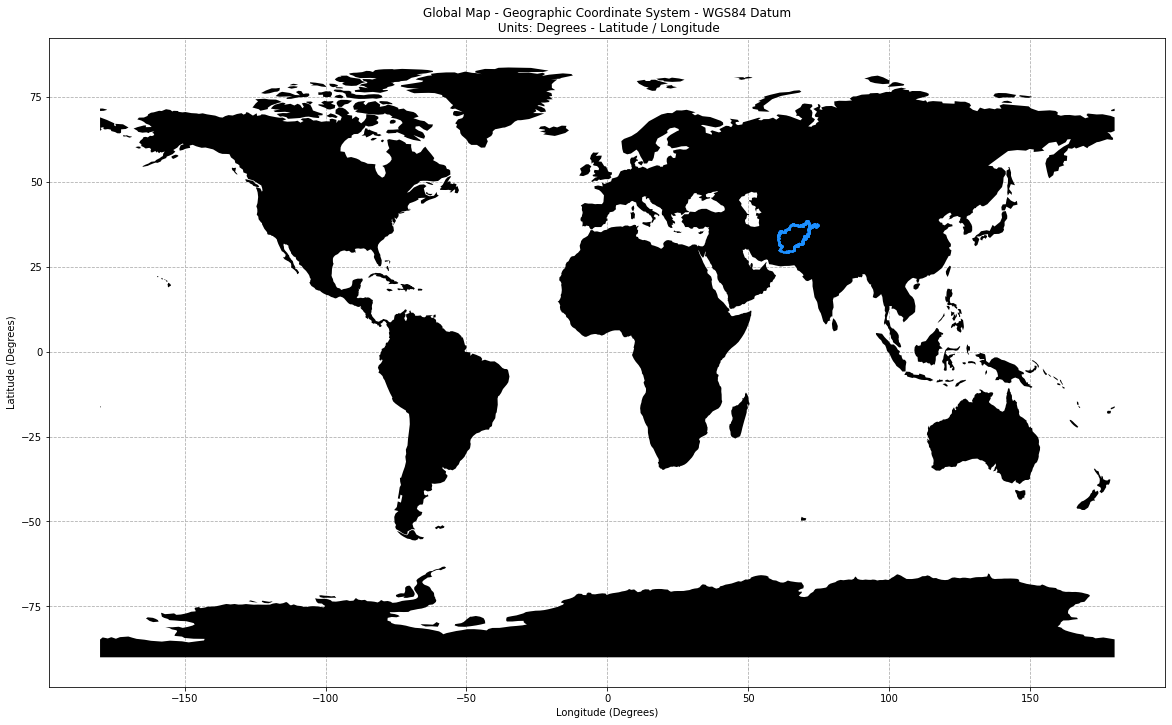

In [ ]:
fig, ax = plt.subplots(figsize = (20, 15))
worldBound.plot(color = 'black', ax = ax)

AF_data.plot(ax = ax, color = 'dodgerblue', marker = '*', markersize = 1)

ax.set(xlabel="Longitude (Degrees)", ylabel="Latitude (Degrees)",
       title="Global Map - Geographic Coordinate System - WGS84 Datum\n Units: Degrees - Latitude / Longitude")
ax.set_axisbelow(True)
plt.grid(linestyle='dashed')

Можно получить не набор точек, а сразу полигон, например, так:

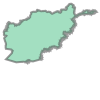

In [ ]:
import shapely.geometry as geometry
from shapely.ops import linemerge, unary_union, polygonize

lss = []

for way in borders:
    ls_coords = []

    for node in way:
        ls_coords.append((node['lon'], node['lat'])) # create a list of node coordinates

    lss.append(geometry.LineString(ls_coords)) # create a LineString from coords


merged = linemerge([*lss]) # merge LineStrings
af_borders = unary_union(merged) # linestrings to a MultiLineString
polygons = list(polygonize(af_borders))
af_poly = geometry.MultiPolygon(polygons)

af_poly

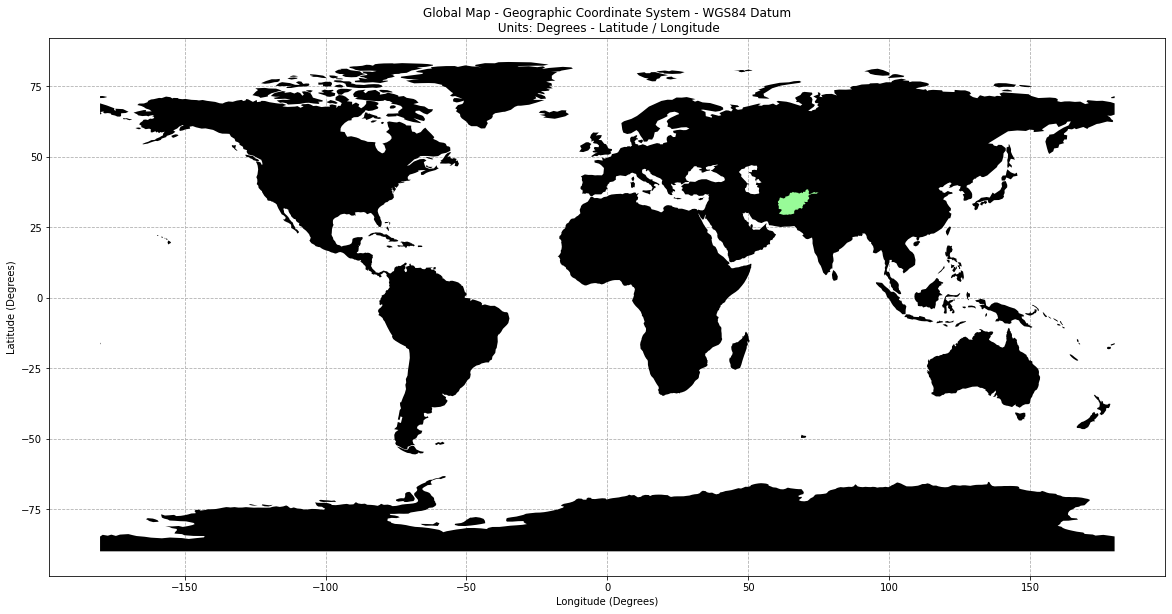

In [ ]:
fig, ax = plt.subplots(figsize = (20, 15))
worldBound.plot(color = 'black', ax = ax)

gpd.GeoDataFrame({'geometry':af_poly}).plot(ax = ax, color = 'palegreen', marker = '*', markersize = 1)

ax.set(xlabel="Longitude (Degrees)", ylabel="Latitude (Degrees)",
       title="Global Map - Geographic Coordinate System - WGS84 Datum\n Units: Degrees - Latitude / Longitude")
ax.set_axisbelow(True)
plt.grid(linestyle='dashed')

In [ ]:
def get_random_point(lat_bounds = (-90, 90), lon_bounds = (-180, 180)):
    
    lat = np.random.rand() * (lat_bounds[1] - lat_bounds[0]) + lat_bounds[0]
    lon = np.random.rand() * (lon_bounds[1] - lon_bounds[0]) + lon_bounds[0]
    return Point(lon, lat)

In [ ]:
af_poly.bounds
#Returns a (minx, miny, maxx, maxy) tuple (float values) that bounds the object.

(60.5176034, 29.3772, 74.889862, 38.4910682)

In [ ]:
af_bbox = {'lon_min': af_poly.bounds[0], 'lon_max': af_poly.bounds[2], 'lat_min': af_poly.bounds[1], 'lat_max': af_poly.bounds[3]}
af_bbox

{'lat_max': 38.4910682,
 'lat_min': 29.3772,
 'lon_max': 74.889862,
 'lon_min': 60.5176034}

In [ ]:
%%time

np.random.seed(8)

random_points = []

point = get_random_point()

while not (af_poly.contains(point) or point.within(af_poly)):
    random_points.append(point)
    point = get_random_point()

random_points.append(point)

print(point)
print(len(random_points))

POINT (62.29730912748983 31.35571595078618)
332
CPU times: user 81.6 ms, sys: 785 µs, total: 82.4 ms
Wall time: 84.3 ms


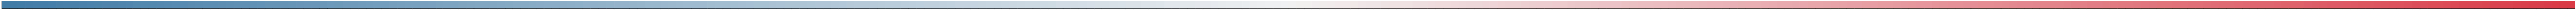

In [ ]:
import matplotlib
from matplotlib.colors import ListedColormap
import seaborn as sns
#matplotlib.colors.CSS4_COLORS
palette = sns.diverging_palette(240, 10, n = len(random_points))
sns.palplot(palette)

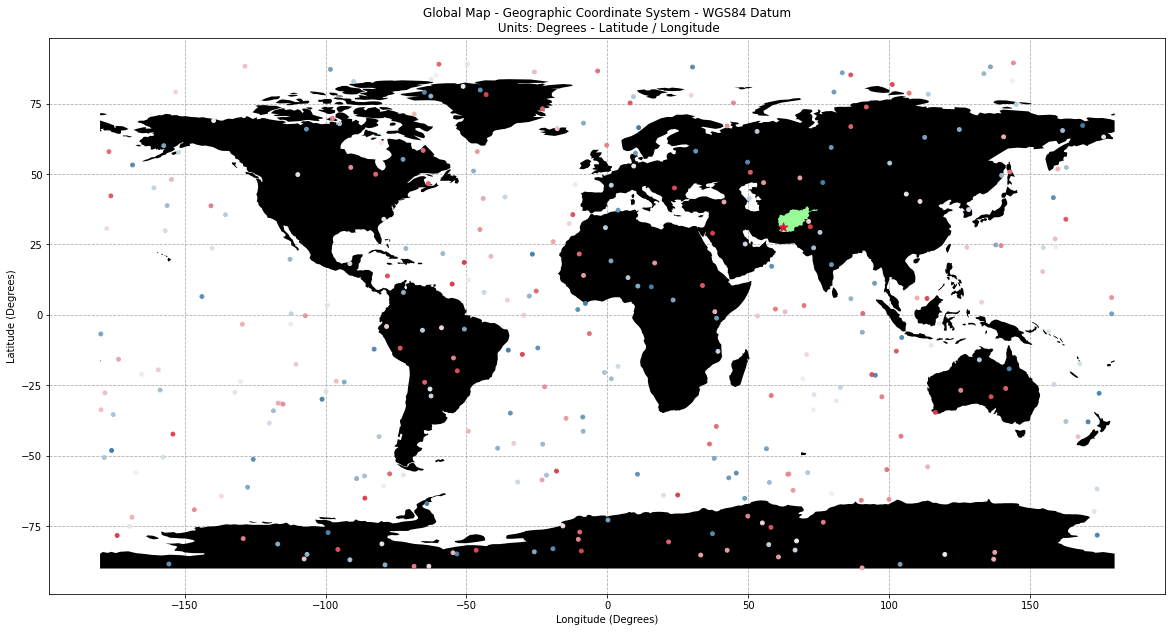

In [ ]:
fig, ax = plt.subplots(figsize = (20, 15))
worldBound.plot(color = 'black', ax = ax)

gpd.GeoDataFrame({'geometry':af_poly}).plot(ax = ax, color = 'palegreen', marker = '*', markersize = 1)

random_walk_df = gpd.GeoDataFrame({'ix': list(range(len(random_points) - 1)), 'geometry':random_points[:-1]})                
random_walk_df.plot(c = 'ix',  cmap = ListedColormap(palette.as_hex()), ax = ax, markersize = 15)

gpd.GeoDataFrame({'geometry':[random_points[-1]]}).plot(ax = ax, color = 'crimson', marker = '*', markersize = 85)

ax.set(xlabel="Longitude (Degrees)", ylabel="Latitude (Degrees)",
       title="Global Map - Geographic Coordinate System - WGS84 Datum\n Units: Degrees - Latitude / Longitude")
ax.set_axisbelow(True)
plt.grid(linestyle='dashed')

How should one find the orientation of a simple polygon?

    Compute the signed area. The orientation is 
    counter-clockwise if this area is positive. 

Давайте теперь сделаем капельку более умный алгоритм - точка порождает квадратное облако стороной в половину длины максимальной стороны bounding box для целевого полигона размером в N точек - из всех точек берём ту, что с наименьшим расстоянием по haversine до центра полигона - повторяем, пока не придём в полигон - в случае плохой инициализации только очень просто застрять на полюсах - поэтому сначала сделаем широким квадрат

In [ ]:
square_half_side = max(af_bbox['lon_max'] - af_bbox['lon_min'], af_bbox['lat_max'] - af_bbox['lat_min']) / 2

square_half_side, af_poly.centroid.coords[0]

(7.1861292999999975, (66.02693533920794, 33.83133703795174))

In [ ]:
def generate_cloud(center_point, size = 10, half_side = 8):

    cloud = []

    for _ in range(size):

        lat_bounds = (max(-90, center_point.y - half_side), min(90, center_point.y + half_side))

        ### когда приближаемся к полюсам, нужно разрешать сэмплировать без ограничений на longitude, иначе застрянем
        ### аналогично для крайних долгот

        if np.isclose(np.abs(center_point.y), 90, atol = 0.5) or np.isclose(np.abs(center_point.x), 180, atol = 0.5):
            lon_bounds = (-180, 180)
        else:
            lon_bounds = (max(-180, center_point.x - half_side), min(180, center_point.x + half_side))

        cloud.append(get_random_point(lat_bounds = lat_bounds, lon_bounds = lon_bounds))
        
    return cloud

In [ ]:
import math

def haversine_function(angle):
    
    return math.sin(angle / 2) * math.sin(angle / 2)

def haversine_distance(point1, point2, radius = 6371):
    
    """
    returns distance between 2 points in spherical coordinates
    """
    
    # Haversine formula
    latitude_delta = math.radians(point2.y) - math.radians(point1.y) # phi
    longitude_delta = math.radians(point2.x) - math.radians(point1.x)  #lambda
    
    a = haversine_function(latitude_delta) + math.cos(math.radians(point1.y)) * math.cos(math.radians(point2.y)) * haversine_function(longitude_delta)
    
    distance = radius * 2 * math.asin(math.sqrt(a))
    return distance

Запускаем

Пример с проходом через полюс

In [ ]:
%%time

np.random.seed(888)

not_so_random_points = []

base_point = get_random_point()

while not (af_poly.contains(base_point) or point.within(base_point)):

    new_cloud = sorted([(p, haversine_distance(p, af_poly.centroid)) for p in generate_cloud(base_point, half_side = square_half_side)], key = lambda x: -x[1])
    if haversine_distance(new_cloud[-1][0], af_poly.centroid) < haversine_distance(base_point, af_poly.centroid):
        base_point = new_cloud[-1][0]

    not_so_random_points.extend(new_cloud)


print(base_point)
print(len(not_so_random_points))

POINT (66.95631447906737 33.8933828598223)
140
CPU times: user 521 ms, sys: 554 µs, total: 522 ms
Wall time: 524 ms


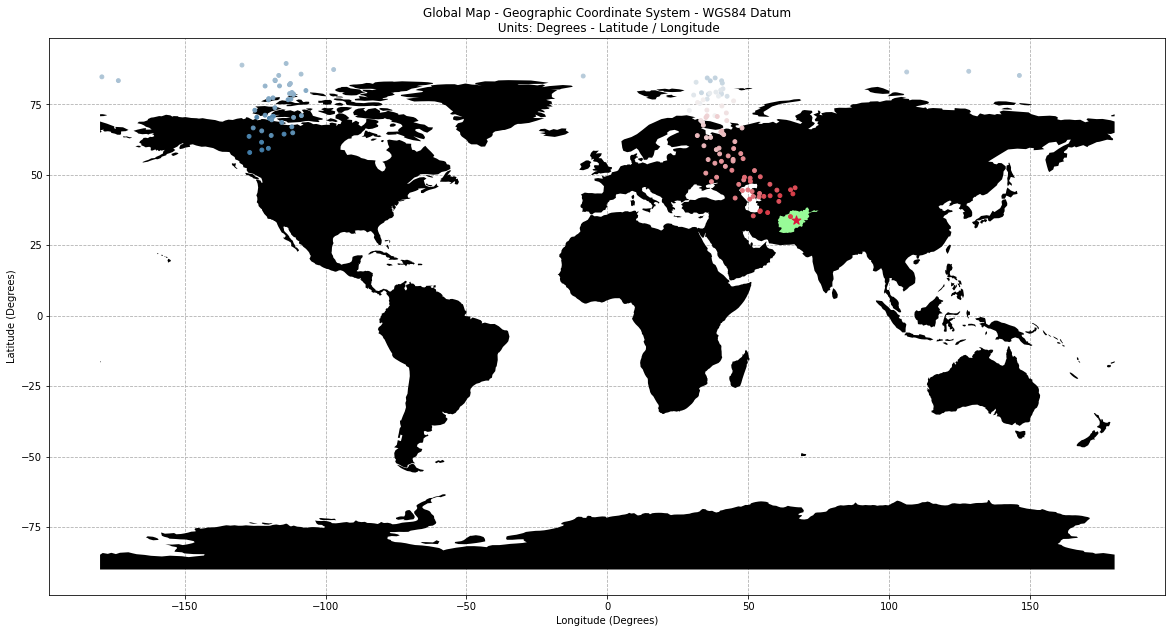

In [ ]:
fig, ax = plt.subplots(figsize = (20, 15))
worldBound.plot(color = 'black', ax = ax)

gpd.GeoDataFrame({'geometry':af_poly}).plot(ax = ax, color = 'palegreen', marker = '*', markersize = 1)

walk_df = gpd.GeoDataFrame({'distance': [d for (p, d) in not_so_random_points[:-1]], 'geometry': [p for (p, d) in not_so_random_points[:-1]]})                
walk_df.plot(c = 'distance',  cmap = ListedColormap(palette.as_hex()), ax = ax, markersize = 15)

gpd.GeoDataFrame({'geometry':[not_so_random_points[-1][0]]}).plot(ax = ax, color = 'crimson', marker = '*', markersize = 85)

ax.set(xlabel="Longitude (Degrees)", ylabel="Latitude (Degrees)",
       title="Global Map - Geographic Coordinate System - WGS84 Datum\n Units: Degrees - Latitude / Longitude")
ax.set_axisbelow(True)
plt.grid(linestyle='dashed')

Пример показывающий, что земля не плоская (шах и мат)

In [ ]:
%%time

np.random.seed(8)

not_so_random_points = []

base_point = get_random_point()

while not (af_poly.contains(base_point) or point.within(base_point)):

    new_cloud = sorted([(p, haversine_distance(p, af_poly.centroid)) for p in generate_cloud(base_point, half_side = square_half_side)], key = lambda x: -x[1])
    if haversine_distance(new_cloud[-1][0], af_poly.centroid) < haversine_distance(base_point, af_poly.centroid):
        base_point = new_cloud[-1][0]

    not_so_random_points.extend(new_cloud)


print(base_point)
print(len(not_so_random_points))

POINT (64.87305812210469 35.89770887171106)
210
CPU times: user 792 ms, sys: 91 µs, total: 792 ms
Wall time: 795 ms


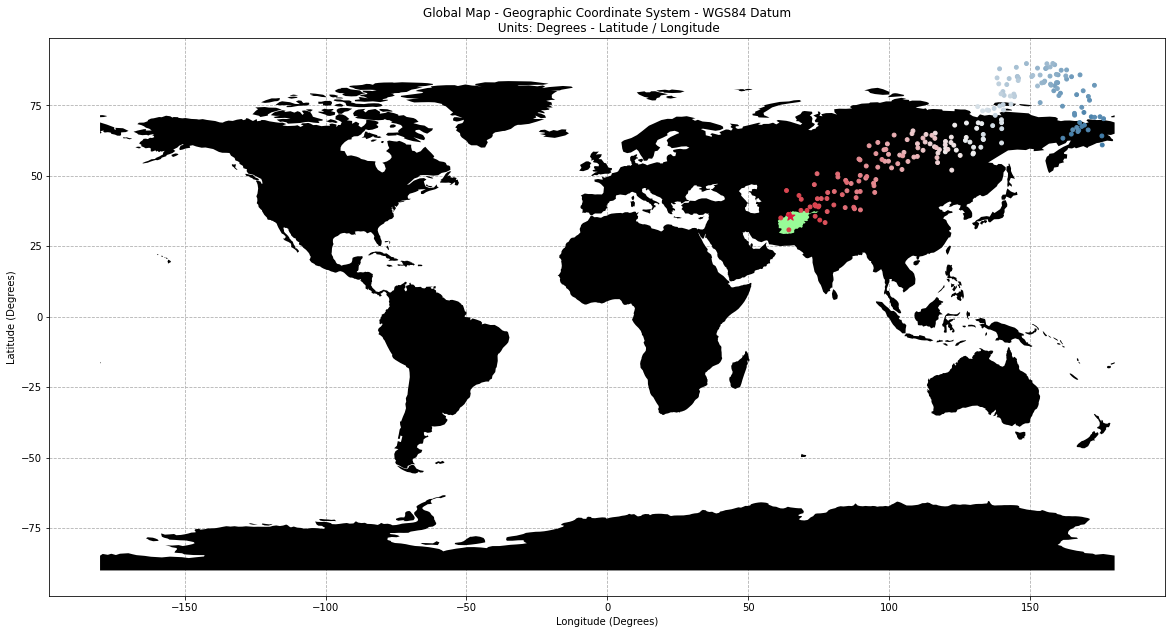

In [ ]:
fig, ax = plt.subplots(figsize = (20, 15))
worldBound.plot(color = 'black', ax = ax)

gpd.GeoDataFrame({'geometry':af_poly}).plot(ax = ax, color = 'palegreen', marker = '*', markersize = 1)

walk_df = gpd.GeoDataFrame({'distance': [d for (p, d) in not_so_random_points[:-1]], 'geometry': [p for (p, d) in not_so_random_points[:-1]]})                
walk_df.plot(c = 'distance',  cmap = ListedColormap(palette.as_hex()), ax = ax, markersize = 15)

gpd.GeoDataFrame({'geometry':[not_so_random_points[-1][0]]}).plot(ax = ax, color = 'crimson', marker = '*', markersize = 85)

ax.set(xlabel="Longitude (Degrees)", ylabel="Latitude (Degrees)",
       title="Global Map - Geographic Coordinate System - WGS84 Datum\n Units: Degrees - Latitude / Longitude")
ax.set_axisbelow(True)
plt.grid(linestyle='dashed')

Визуализируйте пошагово предложенный алгоритм при помощи ``Folium``

In [ ]:
import folium

In [ ]:
m = folium.Map(location = tuple(reversed(af_poly.centroid.coords[0])), ##  it is lat,lon here (oh, man)
               min_zoom = 2, max_zoom = 5, max_bounds = True, 
               zoom_start = 2, tiles='Stamen Terrain')

for i, (p, d) in enumerate(not_so_random_points):
    
    if af_poly.contains(p):
        folium.Marker([p.y, p.x], popup = 'YAY!', tooltip = 'is it here already?', icon = folium.Icon(color='red')).add_to(m)
    else:
        folium.Marker([p.y, p.x], popup=f'@({p.y:.2f},{p.x:.2f}) and still {d:.2f} to go', tooltip = f"i'm point # {i+1}", icon = folium.Icon(color='cadetblue')).add_to(m)

m

## Задание №2. Качество жизни (20 баллов).

Для измерения показателя качества жизни в точке, найденной в предыдущем задании, вам необходимо рассчитать следующую сумму расстояний (в метрах):

1. Расстояние от точки до 5 ближайших __*__ банкоматов, находящихся в стране с наибольшим количеством объектов жилой недвижимости
2. Расстояние от точки до 5 ближайших школ, находящихся в стране с наибольшим количеством аптек в столице
3. Расстояние от точки до 5 ближайших кинотеатров, наодящихся в стране с самым большим отношением числа железнодорожных станций к автобусным остановкам в южной части __**__

__*__ При поиске _N_ ближайших объектов обязательно использовать ``R-tree``

__**__ Южной частью страны является территория, находящаяся к югу от множества точек, равноудаленных от самой северной и самой южной точек страны

In [ ]:
overpass.query('relation["admin_level"="2"][boundary=administrative];out;')

## Задание №3. Поездка по Нью-Йорку (маршрут - 20 баллов, визуализация - 10 баллов).

Добраться __на автомобиле__ от входа в ``Central Park`` __Нью-Йорка__ (со стороны ``5th Avenue``) до пересечения ``Water Street`` и ``Washington Street`` в Бруклине (откуда получаются лучшие фото Манхэттенского моста) довольно непросто - разумеется, из-за вечных пробок. Однако еще сложнее это сделать, проезжая мимо школ, где дети то и дело переходят дорогу в неположенном месте.

Вам необходимо построить описанный выше маршрут, избегая на своем пути школы. Визуализируйте данный маршрут (также добавив школы и недоступные для проезда участки дорог) при помощи ``Folium``

Данные о расположении школ Нью-Йорка можно найти [здесь](https://catalog.data.gov/dataset/2019-2020-school-point-locations)

In [ ]:
!pip install openrouteservice
!pip install fiona

In [ ]:
from folium import Map, Marker, LayerControl
#from folium.plugins import MarkerCluster

from openrouteservice import client

import fiona as fn
from shapely import geometry
from shapely.geometry import shape, Polygon, mapping, MultiPolygon, LineString, Point
from shapely.ops import cascaded_union, transform

reading geodata on [NY schools](https://catalog.data.gov/dataset/2019-2020-school-point-locations)

In [ ]:
#!wget https://data.cityofnewyork.us/api/views/a3nt-yts4/rows.csv

--2020-11-04 15:52:19--  https://data.cityofnewyork.us/api/views/a3nt-yts4/rows.csv
Resolving data.cityofnewyork.us (data.cityofnewyork.us)... 52.206.140.205, 52.206.140.199, 52.206.68.26
Connecting to data.cityofnewyork.us (data.cityofnewyork.us)|52.206.140.205|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified [text/csv]
Saving to: ‘rows.csv.1’

rows.csv.1              [ <=>                ] 343.44K  --.-KB/s    in 0.09s   

2020-11-04 15:52:23 (3.80 MB/s) - ‘rows.csv.1’ saved [351686]



In [ ]:
os.listdir()

['data', 'rows.csv']

In [ ]:
NY_query = \
"""
[out:json];
area["ISO3166-1"="US"][admin_level=2];
(rel["place"="city"]["name" = "New York"](area);
);
out body;
"""

response = requests.get(overpass_url, params={'data': NY_query})
data = response.json()

rel_members = data['elements'][0]['members']

city_center_id = None

for mem in rel_members:

    if mem['type'] == 'node' and mem['role'] == 'label':
        city_center_id = mem['ref']
        break

city_center_id

61785451

In [ ]:
city_center_queue = f'[out:json];node({city_center_id});out geom;'
city_center_data = requests.get(overpass_url, params={'data': city_center_queue}).json()
NY_lat, NY_lon = city_center_data['elements'][0]['lat'], city_center_data['elements'][0]['lon']
NY_lat, NY_lon

(40.7127281, -74.0060152)

In [ ]:
school_data = []

with fn.open('rows.csv', 'r') as NYS_data:

    for record in NYS_data:
        lon, lat = map(float, record['properties']['the_geom'].lstrip('POINT').strip(' ()').split())
        address = record['properties']['Address']
        school_data.append({'geometry':Point(lon, lat), 'address':address})

        #folium.Marker([lat, lon], popup = f"{address}", tooltip = f'lat = {lat:.2f}, lon = {lon:.2f}', icon = folium.Icon(color='cadetblue')).add_to(NY_map)
        #все школы сразу добавлять не будем

solution mostly based on [this manual](https://openrouteservice.org/example-avoid-flooded-areas-with-ors/)

Задаём начальную и конечную точки маршрута

In [287]:
CPN_5th_crossing = Point(-73.949220, 40.796876)
WW_crossing = Point(-73.989559, 40.703304)

NY_f = folium.Figure(width = 1000, height = 600)

NY_map = folium.Map(tiles = 'Stamen Terrain', location = ((NY_lat + 2*CPN_5th_crossing.coords[0][1]) / 3, (NY_lon + 2*CPN_5th_crossing.coords[0][0]) / 3),
                    zoom_start = 12, min_zoom = 5, max_zoom = 20, max_bounds = True).add_to(NY_f)

folium.Marker(tuple(reversed(CPN_5th_crossing.coords[0])), popup = "Central Park North & 5th Avenue", tooltip = 'A', icon = folium.Icon(color='lightblue')).add_to(NY_map)
folium.Marker(tuple(reversed(WW_crossing.coords[0])), popup = "Water St. & Washington St.", tooltip = 'B', icon = folium.Icon(color='lightgreen')).add_to(NY_map)

NY_map

Initializing OSR client

In [ ]:
import getpass
osr_token = getpass.getpass()
osr_client = client.Client(key=osr_token)

··········


Useful functions

In [268]:
import warnings

def style_function(color): # To style data
    return lambda feature: dict(color=color)

# Function to create buffer around tweet point geometries and transform it to the needed coordinate system (WGS84)
def CreateBufferPolygon(point_in, resolution=2, radius=20):    

    """ returns list of points (float, float) which form buffer """

    warnings.filterwarnings(action = 'ignore', category = DeprecationWarning)
    warnings.filterwarnings(action = 'ignore', category = FutureWarning)

    sr_wgs = pyproj.Proj(init='epsg:4326') # WGS84
    sr_utm = pyproj.Proj(init='epsg:32632') # UTM32N
    point_in_proj = pyproj.transform(sr_wgs, sr_utm, *point_in) # Unpack list to arguments
    point_buffer_proj = Point(point_in_proj).buffer(radius, resolution=resolution) # 20 m buffer
    
    # Iterate over all points in buffer and build polygon
    poly_wgs = []
    for point in point_buffer_proj.exterior.coords:
        poly_wgs.append(pyproj.transform(sr_utm, sr_wgs, *point)) # Transform back to WGS84

    warnings.filterwarnings(action = 'default', category = DeprecationWarning)
    warnings.filterwarnings(action = 'default', category = FutureWarning)
        
    return poly_wgs


# Function to request directions with avoided_polygon feature
def CreateRoute(start_coords, end_coords, avoided_point_list, client, n = 0):

    route_request = {'coordinates': [start_coords, end_coords],  ### [(lon, lat), (lon, lat)]
                    #'format_out': 'geojson',
                     'format': 'geojson',
                    'profile': 'driving-car',
                    'preference': 'shortest',
                    'instructions': False,
                    'options': {'avoid_polygons': geometry.mapping(MultiPolygon(avoided_point_list))}} 
    route_directions = client.directions(**route_request)
    
    return route_directions


# Function to create buffer around requested route
def CreateBuffer(route_directions): 
    line_tup = []
    for line in route_directions['features'][0]['geometry']['coordinates']:
        tup_format = tuple(line)
        line_tup.append(tup_format)  

    new_linestring = LineString(line_tup)
    dilated_route = new_linestring.buffer(0.001)
        
    return dilated_route

Построим маршрут без ограничений

In [288]:
avoided_point_list = [] # Create empty list with avoided points
route_directions = CreateRoute(start_coords= CPN_5th_crossing.coords[0], end_coords = WW_crossing.coords[0], 
                               avoided_point_list = avoided_point_list, client = osr_client) # Create regular route with empty avoided_point_list

regular_route = folium.features.GeoJson(data = route_directions,
                        name='Regular Route',
                        style_function = style_function('#ff5050'),
                        overlay=True)
regular_route.add_to(NY_map)

init_route_directions = route_directions
print(f'bbox = {init_route_directions["bbox"]}')

dilated_route = CreateBuffer(init_route_directions) 
folium.features.GeoJson(data = dilated_route,
                            name = 'Dilated Route',
                            style_function = style_function('#dedb16'),
                            overlay = True).add_to(NY_map)


NY_map

bbox = [-73.996072, 40.698582, -73.949234, 40.796882]


Теперь будем итеративно перестраивать маршрут, пока не окажется ни одной школы рядом с ним

Посмотрим, насколько много точек вблизи старта мешают на исходном треке

In [289]:
school_data_df = gpd.GeoDataFrame(school_data).drop_duplicates() ### разный нейминг школ, но адреса одни и те же - дроп сильно ускоряет процесс дальше
school_data_df['distance_to_POI'] = school_data_df['geometry'].apply(lambda x: haversine_distance(x, CPN_5th_crossing))
school_data_df.sort_values(by = 'distance_to_POI', ascending = True, inplace = True)
school_data_df = school_data_df.reset_index(drop = True)
school_data_df.head()

,geometry,address,distance_to_POI
0,POINT (-73.95015 40.79846),21 WEST 111 STREET,0.192790
1,POINT (-73.95015 40.79846),20 WEST 112 STREET,0.192790
2,POINT (-73.94786 40.79503),1615 MADISON AVENUE,0.234974
3,POINT (-73.94849 40.79365),1573 MADISON AVENUE,0.364027
4,POINT (-73.94455 40.79610),141 EAST 111 STREET,0.402786


In [290]:
school_polygons = []
poly_pts = []

for i, data in tqdm(school_data_df[:10].iterrows()):

    # Create buffer polygons around schools with 20 m radius and low resolution
    school_poly_pts = CreateBufferPolygon(data['geometry'].coords[0],
                                resolution = 2, # low resolution to keep polygons lean
                                radius = 100) # meters

    poly_pts.append(poly)

    poly = Polygon(school_poly_pts)

    school_polygons.append(poly)

    lon, lat = data['geometry'].coords[0]
    address = data['address']

    folium.Marker([lat, lon], popup = f"{address} - #{i+1}", tooltip = f'lat = {lat:.2f}, lon = {lon:.2f}', icon = folium.Icon(color='cadetblue')).add_to(NY_map)
    folium.features.GeoJson(data = poly, name=f'School {i + 1}',
                        style_function = style_function('#50edff'),
                        overlay=True).add_to(NY_map)

In [291]:
NY_map

Проверим, что пересечение работает

In [292]:
poly = school_polygons[8]
poly.intersects(dilated_route), poly.overlaps(dilated_route)

(True, True)

In [ ]:
# dilated_route.exterior.coords.xy

Let's re-initialize map

In [293]:
warnings.filterwarnings(action = 'ignore', category = DeprecationWarning)

CPN_5th_crossing = Point(-73.949220, 40.796876)
WW_crossing = Point(-73.989559, 40.703304)

NY_f = folium.Figure(width = 1000, height = 600)

NY_map = folium.Map(tiles = 'Stamen Terrain', location = ((NY_lat + 2*CPN_5th_crossing.coords[0][1]) / 3, (NY_lon + 2*CPN_5th_crossing.coords[0][0]) / 3),
                    zoom_start = 12, min_zoom = 5, max_zoom = 20, max_bounds = True).add_to(NY_f)

folium.Marker(tuple(reversed(CPN_5th_crossing.coords[0])), popup = "Central Park North & 5th Avenue", tooltip = 'A', icon = folium.Icon(color='lightblue')).add_to(NY_map)
folium.Marker(tuple(reversed(WW_crossing.coords[0])), popup = "Water St. & Washington St.", tooltip = 'B', icon = folium.Icon(color='lightgreen')).add_to(NY_map)

avoided_point_list = [] # Create empty list with avoided points
route_directions = CreateRoute(start_coords= CPN_5th_crossing.coords[0], end_coords = WW_crossing.coords[0], 
                               avoided_point_list = avoided_point_list, client = osr_client) # Create regular route with empty avoided_point_list

regular_route = folium.features.GeoJson(data = route_directions,
                        name='Regular Route',
                        style_function = style_function('#ff5050'),
                        overlay=True)
regular_route.add_to(NY_map)

init_route_directions = route_directions
print(f'bbox = {init_route_directions["bbox"]}')

dilated_route = CreateBuffer(init_route_directions) 
folium.features.GeoJson(data = dilated_route,
                            name = 'Dilated Route',
                            style_function = style_function('#dedb16'),
                            overlay = True).add_to(NY_map)


NY_map

bbox = [-73.996072, 40.698582, -73.949234, 40.796882]


Тут важно понимать, что dilated_route полигон и полигоны вокруг школ могут пересекаться, но сам маршрут заезжать на полигоны вокруг школ не должен

In [294]:
warnings.filterwarnings(action = 'ignore', category = DeprecationWarning)

school_polygons = []
poly_pts = []

radius = 80  # meters

try:
    for i, data in tqdm(school_data_df.iterrows(), total = len(school_data_df)):

        # Create buffer polygons around schools with 20 m radius and low resolution
        school_poly_pts = CreateBufferPolygon(data['geometry'].coords[0],
                                    resolution = 2, # low resolution to keep polygons lean
                                    radius = radius)
        
        poly_pts.append(school_poly_pts)

        poly = Polygon(school_poly_pts)
        school_polygons.append(poly)

        lon, lat = data['geometry'].coords[0]
        address = data['address']


        if poly.intersects(dilated_route):

            avoided_point_list.append(poly)
            print(f'avoiding school @ lat = {lat}, lon = {lon}, {address} - route rebuilt')
            folium.Marker([lat, lon], popup = f"{address} - #{i+1}", tooltip = f'lat = {lat:.2f}, lon = {lon:.2f}', icon = folium.Icon(color='cadetblue')).add_to(NY_map)
            folium.features.GeoJson(data = poly, name=f'School {i + 1}',
                            style_function = style_function('#50edff'),
                            overlay=True).add_to(NY_map)

            # Create new route and buffer
            route_directions = CreateRoute(start_coords = CPN_5th_crossing.coords[0], end_coords = WW_crossing.coords[0], 
                                           avoided_point_list = avoided_point_list, client = osr_client)
            dilated_route = CreateBuffer(route_directions)

    folium.features.GeoJson(data = route_directions,
                            name = 'Alternative Route',
                            style_function = style_function('#006600'),
                            overlay = True).add_to(NY_map)

    folium.features.GeoJson(data = dilated_route,
                            name = 'Dilated Route',
                            style_function = style_function('#8aba6e'),
                            overlay = True).add_to(NY_map)

    print('Alternative route generated')
except Exception: 
    print('Sorry, there is no route available between the requested points because of too many objects inbetween')

NY_map

avoiding school @ lat = 40.79309892090311, lon = -73.95136760096838, 1 EAST 104 STREET - route rebuilt
avoiding school @ lat = 40.79293239005381, lon = -73.94717117480322, 105 EAST 106TH STREET - route rebuilt
avoiding school @ lat = 40.79196611074631, lon = -73.94687941536989, 1680 LEXINGTON AVENUE - route rebuilt
avoiding school @ lat = 40.791444873611326, lon = -73.94745043345964, 131 EAST 104 STREET - route rebuilt
avoiding school @ lat = 40.78079873382572, lon = -73.95559403260066, 110 EAST  88 STREET - route rebuilt
avoiding school @ lat = 40.777737369408904, lon = -73.9604271407208, 45 EAST  81 STREET - route rebuilt
avoiding school @ lat = 40.74651018054297, lon = -73.98107095330838, 111 EAST  33RD STREET - route rebuilt
avoiding school @ lat = 40.73912193257602, lon = -73.98532394737263, 127 EAST  22 STREET - route rebuilt
avoiding school @ lat = 40.735361830024594, lon = -73.98706400797131, 40 IRVING PLACE - route rebuilt
avoiding school @ lat = 40.71509794557132, lon = -73.9